In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt 
%matplotlib inline


In [2]:
is_colab = False

#### Use GPU?

In [3]:
USE_GPU = "Yes"

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


#### Download data and create Batcher

In [4]:
from src.download_data_colab import download_data

URL = 'http://mattmahoney.net/dc/text8.zip' 
download_data(URL, is_colab=False, save_model_drive = False)

File already downloaded!


In [5]:
from src.batcher import BatcherNS

text_file = open("text8", "r")
# 63641 - words with frequency higher than 5
dataset = BatcherNS(text_file,neg_samples = 10, window_size=4, voc_threshold=63641)

#### Define model, optimizer and loss

In [6]:
from src.model import CBOW_NS

model = CBOW_NS(dataset.word_2_id, window_size = dataset.window_size)

dataloader = DataLoader(dataset, batch_size = 64)
optimizer = optim.SGD(model.parameters(),lr = 0.05)
loss = nn.CrossEntropyLoss()

#### Train model

In [ ]:
from src.train import train_loopNS


train_loss = train_loopNS(model, dataloader, optimizer, loss, device, epochs = 1, save_model=False)

#### Visualization of pre-trained vectors

In [8]:
def t_sne(model):
    vectors = []
    words = []
    
    model.eval()
    for word, _ in model.word_2_id.items():
        vectors.append(model.get_vector(word).detach().numpy())
        words.append(word)
        
    tsne = TSNE()
    values = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(20, 16)) 
    for i, (x,y) in enumerate(values,0):
        
        plt.scatter(x,y)
        plt.annotate(words[i],
                     xy =(x, y),
                     xytext = (5,2),
                     textcoords='offset points')

KeyboardInterrupt: 

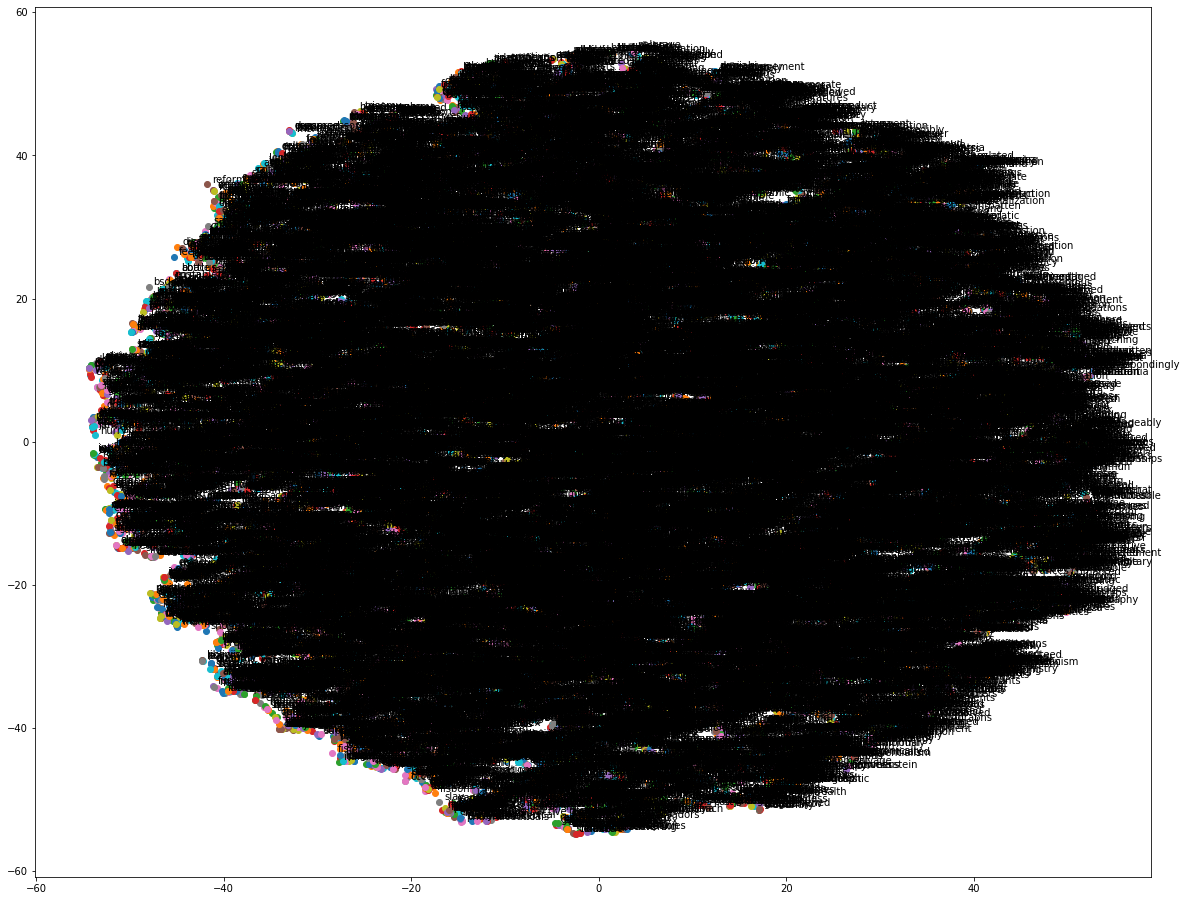

In [11]:
t_sne(model)

### Intrinsic evaluation

In [ ]:
!wget http://download.tensorflow.org/data/questions-words.txt

In [78]:
U, V = map(lambda x: x.detach(), list(model.parameters())[:2])
mean_weight = (U+V)/2

In [83]:
import gensim

eval_model = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=model.emb_dim)
eval_model.add(list(model.word_2_id.keys()), weights=mean_weight)

In [85]:
analogy_score = eval_model.evaluate_word_analogies("questions-words.txt")